# Spatio-temporal Transcriptomics

Toy dataset from López-Lopera et al. (2019)

- Data download: https://github.com/anfelopera/PhysicallyGPDrosophila

In [1]:
import numpy as np
import torch

from torch.nn import Parameter
from gpytorch.constraints import Interval
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import path

from lafomo.utilities.torch import get_image
from lafomo.datasets import DrosophilaSpatialTranscriptomics
from lafomo.models import MultiOutputGP, PartialLFM
from lafomo.models.pdes import ReactionDiffusion
from lafomo.datasets import ToySpatialTranscriptomics, P53Data
from lafomo.configuration import VariationalConfiguration
from lafomo.plot import Plotter, plot_before_after
from lafomo.trainers import PDETrainer
from lafomo.utilities.torch import discretise
from lafomo.utilities.fenics import interval_mesh

In [2]:
def plot_spatiotemporal_data(images):
    """Data"""
    fig = plt.figure()
    grid = ImageGrid(fig, 111,  # similar to subplot(144)
                     nrows_ncols=(2, 3),
                     axes_pad=(0.45, 0.15),
                     label_mode="1",
                     share_all=True,
                     cbar_location="right",
                     cbar_mode="each",
                     cbar_size="7%",
                     cbar_pad="2%",
                     )

    for image, ax, cax in zip(images, grid, grid.cbar_axes):
        print(image.shape)
        im = ax.imshow(image, extent=[0, 1, 0, 1], origin='lower')#,  vmin=vlim[0], vmax=vlim[1])
        ax.axis('off')
        cb = plt.colorbar(im, cax=cax)
        cb.set_ticks(np.linspace(image.min(), int(image.max()/100)*100, 6))

    # This affects all axes because we set share_all = True.
    grid.axes_llc.set_xticks([-2, 0, 2])
    grid.axes_llc.set_yticks([-2, 0, 2])

(64, 8)
(57, 8)
(64, 8)
(64, 8)
(57, 8)
(64, 8)


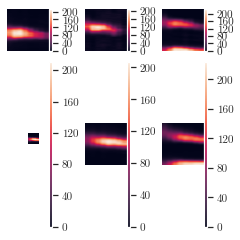

In [3]:
kr_dataset = DrosophilaSpatialTranscriptomics(gene='kr', data_dir='../../../data')
kni_dataset = DrosophilaSpatialTranscriptomics(gene='kni', data_dir='../../../data')
gt_dataset = DrosophilaSpatialTranscriptomics(gene='gt', data_dir='../../../data')

drosophila = True

if drosophila:
    dataset = DrosophilaSpatialTranscriptomics(gene='kr', data_dir='../../../data')

    data = next(iter(dataset))
    tx, y_target = data
    lengthscale = 10
    images = [get_image(dataset.orig_data, i)
          for i in range(2, 4)
          for dataset in [kr_dataset, kni_dataset, gt_dataset]
          ]

    plot_spatiotemporal_data(images)
else:
    dataset = ToySpatialTranscriptomics(data_dir='../../../data/')
    data = next(iter(dataset))
    tx, y_target = data
    lengthscale = 0.2

num_inducing = int(tx.shape[1] * 2/3)



We can either create a simple unit interval mesh

In [4]:
from dolfin import *

mesh = UnitIntervalMesh(40)

Alternatively, if our spatial data is not uniformly spaced, we can define a custom mesh as follows.

In [5]:
# We calculate a mesh that contains all possible spatial locations in the dataset

spatial = np.unique(tx[1, :])
mesh = interval_mesh(spatial)

# The mesh coordinates should match up to the data:
print('Matching:', all(spatial == mesh.coordinates().reshape(-1)))
#plot(mesh)
print(type(spatial))

Matching: True
<class 'numpy.ndarray'>


Set up GP model

In [6]:
ts = tx[0, :].unique().sort()[0].numpy()
xs = tx[1, :].unique().sort()[0].numpy()
t_diff = ts[-1]-ts[0]
x_diff = xs[-1]-xs[0]
extent = [ts[0], ts[-1], xs[0], xs[-1]]
print(extent)

inducing_points = torch.stack([
    ts[0] + t_diff * torch.rand((1, num_inducing)),
    xs[0] + x_diff * torch.rand((1, num_inducing))
], dim=2)
print(inducing_points.shape)
gp_kwargs = dict(use_ard=True,
                 use_scale=False,
                 # lengthscale_constraint=Interval(0.1, 0.3),
                 learn_inducing_locations=False,
                 initial_lengthscale=lengthscale)
gp_model = MultiOutputGP(inducing_points, 1, **gp_kwargs)
gp_model.double();

[53.925, 97.675, 25.5, 88.5]
torch.Size([1, 341, 2])


Set up PDE

In [7]:
t_range = (ts[0], ts[-1])
print(t_range)
time_steps = dataset.num_discretised

fenics_model = ReactionDiffusion(t_range, time_steps, mesh)

config = VariationalConfiguration(
    initial_conditions=False,
    num_samples=25
)

sensitivity = Parameter(torch.ones((1, 1), dtype=torch.float64), requires_grad=True)
decay = Parameter(0.1*torch.ones((1, 1), dtype=torch.float64), requires_grad=True)
diffusion = Parameter(0.01*torch.ones((1, 1), dtype=torch.float64), requires_grad=True)
fenics_params = [sensitivity, decay, diffusion]

lfm = PartialLFM(1, gp_model, fenics_model, fenics_params, config)

(53.925, 97.675)


In [8]:
optimizer = torch.optim.Adam(lfm.parameters(), lr=0.07)
trainer = PDETrainer(lfm, optimizer, dataset, track_parameters=list(lfm.fenics_named_parameters.keys()))

t_sorted, dp [53.925 60.175 66.425 72.675 78.925 85.175 91.425 97.675] 6.25
x dp is set to 1.0
t_sorted, dp [25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5
 39.5 40.5 41.5 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5
 53.5 54.5 55.5 56.5 57.5 58.5 59.5 60.5 61.5 62.5 63.5 64.5 65.5 66.5
 67.5 68.5 69.5 70.5 71.5 72.5 73.5 74.5 75.5 76.5 77.5 78.5 79.5 80.5
 81.5 82.5 83.5 84.5 85.5 86.5 87.5 88.5] 1.0


Now let's see some samples from the GP and corresponding LFM output

yprev u torch.Size([25, 64]) torch.Size([25, 1, 8, 64])
torch.Size([25, 8, 64])
torch.Size([1, 512]) torch.Size([1, 512])
torch.Size([1, 512, 512])
shape


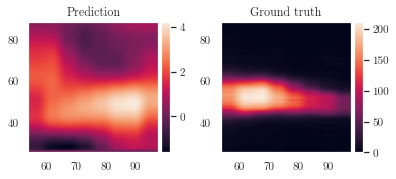

In [51]:
out = lfm(tx).mean
out = out.detach().view(num_t, num_x)
y_target = trainer.y_target
print('shape', )
plot_before_after(
    out.transpose(0, 1),
    y_target.view(num_t, num_x).detach().transpose(0, 1),
    extent,
    titles=['Prediction', 'Ground truth']
)

8 64 7
yprev u torch.Size([25, 64]) torch.Size([25, 1, 8, 64])
torch.Size([25, 8, 64])
yprev u torch.Size([25, 64]) torch.Size([25, 1, 8, 64])
torch.Size([25, 8, 64])


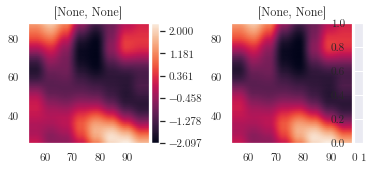

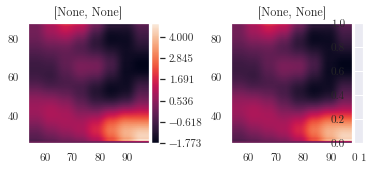

In [12]:
num_t = trainer.tx[0, :].unique().shape[0]
num_x = trainer.tx[1, :].unique().shape[0]
print(num_t, num_x, lfm.time_steps)

# gp_model.covar_module.lengthscale = 0.3*0.3 * 2
out = gp_model(tx.transpose(0, 1))

sample = out.sample(torch.Size([lfm.config.num_samples])).permute(0, 2, 1)
real = torch.tensor(dataset.orig_data[trainer.t_sorted, 2]).unsqueeze(0)


plot_before_after(
    sample[0].detach().view(num_t, num_x).transpose(0, 1),
    real.squeeze().view(num_t, num_x).transpose(0, 1),
    extent
)

real = real.repeat(lfm.config.num_samples, 1, 1)
sample = sample.view(lfm.config.num_samples, 1, num_t, num_x)
real = real.view(lfm.config.num_samples, 1, num_t, num_x)

out = lfm.solve_pde(sample)
real_out = lfm.solve_pde(real)

plot_before_after(
    out.mean(0).detach().transpose(0, 1),
    real_out[0].detach().transpose(0, 1),
    extent
)


yprev u torch.Size([25, 64]) torch.Size([25, 1, 8, 64])
torch.Size([25, 8, 64])
torch.Size([1, 512]) torch.Size([1, 512])
torch.Size([1, 512, 512])
tensor(171.9727, dtype=torch.float64, grad_fn=<MaxBackward1>) torch.Size([512, 1]) torch.Size([512, 1])
Epoch 001/001 - Loss: 425.49 (419.95 5.54) λ: [ 9.67699003 10.54409824] s: 1.3123224778969815 dif: 0.20352274062113201 dec: 0.6664642554441916


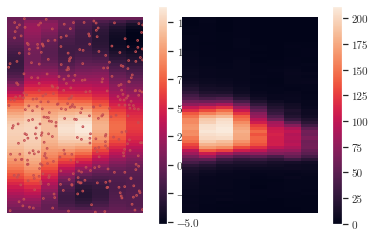

In [24]:
trainer.train(1)

In [45]:
filepath = path.join('../../../experiments', 'dros-kr', 'partial', 'savedmodel')

# lfm.save(filepath)

In [46]:
lfm = PartialLFM.load(filepath,
                      gp_cls=MultiOutputGP,
                      gp_args=[inducing_points, 1],
                      gp_kwargs=gp_kwargs,
                      lfm_args=[1, fenics_model, fenics_params, config])
# lfm = PartialLFM(gp_model, fenics_model, fenics_params, config)

gp_model = lfm.gp_model
optimizer = torch.optim.Adam(lfm.parameters(), lr=0.07)
trainer = PDETrainer(lfm, optimizer, dataset, track_parameters=list(lfm.fenics_named_parameters.keys()))

t_sorted, dp [53.925 60.175 66.425 72.675 78.925 85.175 91.425 97.675] 6.25
x dp is set to 1.0
t_sorted, dp [25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5
 39.5 40.5 41.5 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5
 53.5 54.5 55.5 56.5 57.5 58.5 59.5 60.5 61.5 62.5 63.5 64.5 65.5 66.5
 67.5 68.5 69.5 70.5 71.5 72.5 73.5 74.5 75.5 76.5 77.5 78.5 79.5 80.5
 81.5 82.5 83.5 84.5 85.5 86.5 87.5 88.5] 1.0


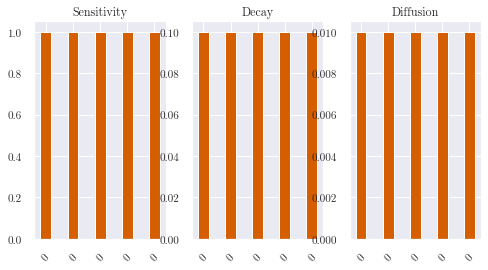

In [11]:
plotter = Plotter(lfm, np.arange(1))


labels = ['Sensitivity', 'Decay', 'Diffusion']
kinetics = list()
for key in lfm.fenics_named_parameters.keys():
    kinetics.append(trainer.parameter_trace[key][-1].squeeze().numpy())

plotter.plot_double_bar(kinetics, labels)

plotter.plot_latents()